<a href="https://colab.research.google.com/github/Ibnuamrithaher/Mechine-Learning-And-Deep-Learning/blob/main/Regression%20Evaluation/Part9%20-%20ElasticNet%20Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 MB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.3-py2.py3-none-any.whl size=41032443 sha256=126de054ff2b1ae6fc76a57e8a1dab5146019182b4f77ec1544cd9daadbdec09
  Stored in directory: /root/.cache/pip/wheels/25/9b/68/61b665f8682276ffbc7fa54bae3ccc541be2ed103979770b9b
  Created wheel for jcopml: filename=jcopml-1.2.7-py2.py3-none-any.whl size=45916 sha256=8e4136f83294fbef66f5c90853786eb779592cd5118412ef340ed3c375f667c8
  Stored in directory: /root/.cache/pip/wheels/77/a7/60/c75983f4da5b630422325c5048591b6ee9e2ce123bf2b7b357
Successfully built luwiji jcopml


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## **Import Data**

In [3]:
url = "https://raw.githubusercontent.com/Ibnuamrithaher/Mechine-Learning-And-Deep-Learning/refs/heads/main/Regression%20Evaluation/Data/taxi_fare.csv"
df = pd.read_csv(url, parse_dates=["pickup_datetime"])
df.dropna(inplace=True)

pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.day_of_week
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)

df['distanc'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude'], inplace=True)

df.head()


,fare_amount,passenger_count,year,month,day,hour,distanc
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


## **Dataset Splitting**

In [4]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((15134, 6), (3784, 6), (15134,), (3784,))

## **Training**

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import grid_search_params as gsp


In [7]:
gsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'algo__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

In [9]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count','year','distanc']),
    ("categoric", cat_pipe(encoder='onehot'), ["month","day","hour"]),
])

pipeline = Pipeline([
    ("prep",preprocessor),
    ("algo",ElasticNet())
])

model = RandomizedSearchCV(pipeline, gsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train,y_train)

#Evaluation
print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'prep__numeric__poly__interaction_only': False, 'prep__numeric__poly__degree': 3, 'algo__l1_ratio': 1, 'algo__fit_intercept': False, 'algo__alpha': 0.01}
0.7074431473511158 0.7056537223855477 0.7338542540106237


## **Feature Importance**

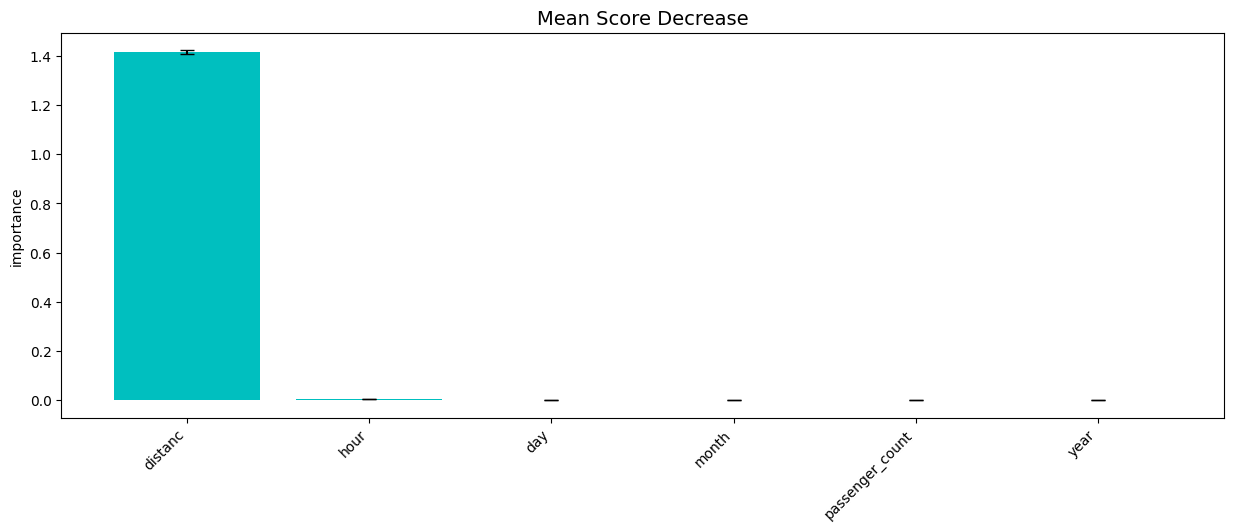

In [10]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

## **Evaluation**

In [11]:
from jcopml.plot import plot_residual

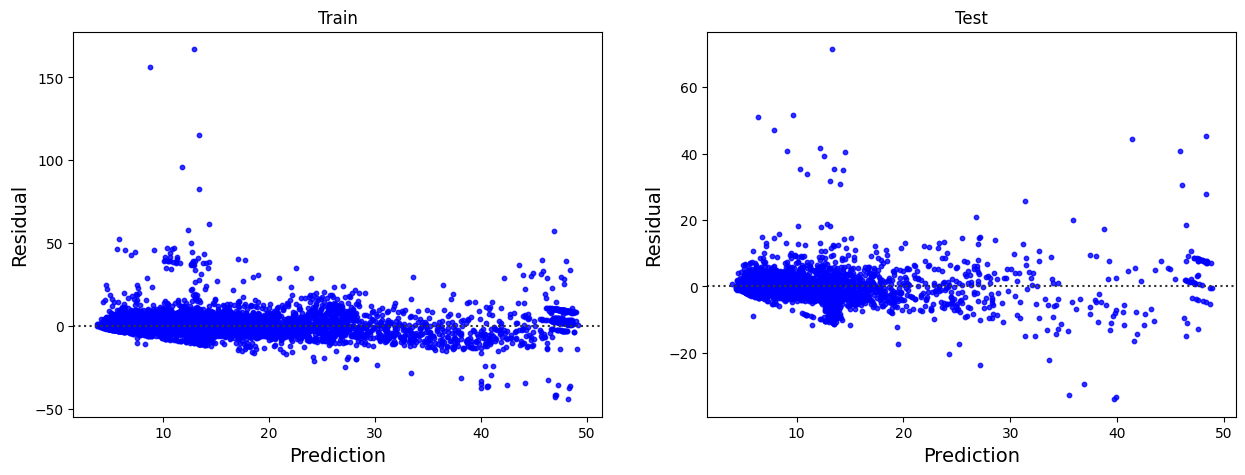

In [12]:
plot_residual(X_train, y_train, X_test, y_test, model)

### **Masih saja ada unbalanced, mari kita cek datanya**

In [15]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values("error", ascending=False).head(10)


,passenger_count,year,month,day,hour,distanc,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,167.086493
1483,1.0,2009,8,4,21,0.000416,165.00,156.205534
6630,1.0,2014,5,4,1,0.000000,128.83,115.457517
14142,1.0,2014,12,4,10,0.045860,108.00,96.205854
12915,1.0,2011,9,2,1,0.000000,96.00,82.594006
10524,1.0,2010,5,1,14,0.000000,75.80,61.468018
12349,1.0,2010,5,5,15,0.434492,104.67,57.735110
1494,1.0,2009,9,1,14,0.000031,70.00,57.664599
2432,1.0,2012,11,4,1,0.003817,58.60,52.711543
2346,1.0,2009,2,5,0,0.000000,63.00,50.354886


In [17]:
df[df.fare_amount < 0]


,fare_amount,passenger_count,year,month,day,hour,distanc
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
13032,-3.0,4.0,2013,8,4,8,0.001425
